# Comparison of Co-located Tiltmeter and Seismometer-derived Tilt from a 2012 Eruption of Volcan de Santiaguito

## Download seismic and tilt data with PySEP

PySEP configuration file

In [18]:
!cat santiaguito2012.yaml

event_tag: Santiaguito2012
client: IRIS
client_debug: false
event_selection: default
origin_time: 2012-01-08T05:34:58
event_latitude: 14.7427
event_longitude: -91.565498
event_depth_km: 0
event_magnitude: 0
seconds_before_ref: 1
seconds_after_ref: 14400
networks: YL
stations: SJAK
channels: HHE,HHN,HHZ,HAE,HAN
locations: '*'
demean: false
detrend: false
remove_response: false
resample_freq: null
remove_clipped: true
remove_insufficient_length: true
remove_masked_data: true
write_files: inv,sac
plot_files: null
log_level: WARNING


In [19]:
!pysep -c santiaguito2012.yaml -o

[2023-09-08 11:23:33] - pysep - INFO: overwriting default parameters with config file: 'santiaguito2012.yaml'
[2023-09-08 11:23:33] - pysep - DEBUG: event_tag: None -> Santiaguito2012
[2023-09-08 11:23:33] - pysep - DEBUG: origin_time: None -> 2012-01-08 05:34:58
[2023-09-08 11:23:33] - pysep - DEBUG: event_latitude: None -> 14.7427
[2023-09-08 11:23:33] - pysep - DEBUG: event_longitude: None -> -91.565498
[2023-09-08 11:23:33] - pysep - DEBUG: event_depth_km: None -> 0
[2023-09-08 11:23:33] - pysep - DEBUG: event_magnitude: None -> 0
[2023-09-08 11:23:33] - pysep - DEBUG: seconds_before_ref: 100 -> 1
[2023-09-08 11:23:33] - pysep - DEBUG: seconds_after_ref: 300 -> 14400
[2023-09-08 11:23:33] - pysep - DEBUG: networks: * -> YL
[2023-09-08 11:23:33] - pysep - DEBUG: stations: * -> SJAK
[2023-09-08 11:23:33] - pysep - DEBUG: channels: * -> HHE,HHN,HHZ,HAE,HAN
[2023-09-08 11:23:33] - pysep - DEBUG: demean: True -> False
[2023-09-08 11:23:33] - pysep - DEBUG: detrend: True -> False
[2023-0

## Run SeiNei to estimate tilt

Specifing 60-7200s passband to ensure it is the same for both tiltmeter and seismometer data

In [23]:
!seinei ./2012-01-08T053458_GUATEMALA/inv.xml ./2012-01-08T053458_GUATEMALA/SAC/2012*HH?.sac -lpp 60 -hpp 7200

Low-pass period: 60.00s
High-pass period: 7200.00s
/home/mchristo/miniconda3/envs/py3/lib/python3.10/site-packages/seinei/bin/seinei.py:124: RuntimeWarning: divide by zero encountered in divide
  DATA = np.fft.rfft(tr.data)/Ct
/home/mchristo/miniconda3/envs/py3/lib/python3.10/site-packages/seinei/bin/seinei.py:124: RuntimeWarning: invalid value encountered in divide
  DATA = np.fft.rfft(tr.data)/Ct
Low-pass period: 60.00s
High-pass period: 7200.00s
Low-pass period: 60.00s
High-pass period: 7200.00s


## Open tiltmeter and seismometer-tilt files, plot together to compare

In [24]:
import obspy
import glob
import matplotlib.pyplot as plt
import numpy as np

In [26]:
# Seismometer-derived tilt
stSeisTilt = obspy.core.stream.Stream()
for file in glob.glob("./2012-01-08T053458_GUATEMALA/SAC/tilt*.sac"):
    stSeisTilt += obspy.read(file)
    
# Tiltmeter tilt
stTilt = obspy.core.stream.Stream()
for file in glob.glob("./2012-01-08T053458_GUATEMALA/SAC/2012*HA?.sac"):
    stTilt += obspy.read(file)

# Remove response and filter tilt
stTilt.attach_response("./2012-01-08T053458_GUATEMALA/inv.xml")

stTilt.detrend(type="linear")

# Filter tiltmeter
stTilt.filter(
    type="bandpass",
    freqmin=1.0/7200,
    freqmax=1.0/60,
    corners=4,
    zerophase=False,
)

stTilt.remove_response(output="DEF")

/home/mchristo/miniconda3/envs/py3/lib/python3.10/site-packages/obspy/core/inventory/response.py:1205: UserWarning: The unit 'URADIAN' is not known to ObsPy. It will be passed in to evalresp as 'undefined'. This should result in evalresp using the response as is, without adding any integration or differentiation and the 'output' parameter (here: 'DEF') not having any effect. Please double check output data.
  warnings.warn(msg)


2 Trace(s) in Stream:
YL.SJAK..HAE | 2012-01-08T05:34:57.005000Z - 2012-01-08T09:34:57.995000Z | 100.0 Hz, 1440100 samples
YL.SJAK..HAN | 2012-01-08T05:34:57.005000Z - 2012-01-08T09:34:57.995000Z | 100.0 Hz, 1440100 samples

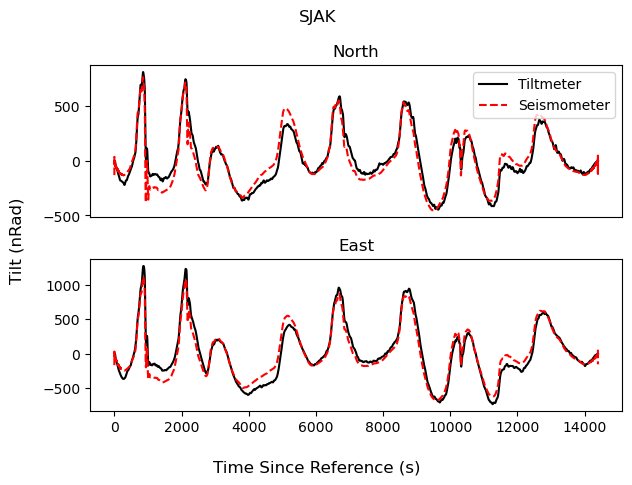

In [35]:
hhn = stSeisTilt.select(channel="HHN")[0].data
thhn = stSeisTilt.select(channel="HHN")[0].times()

han = stTilt.select(channel="HAN")[0].data
than = stTilt.select(channel="HAN")[0].times()

hhe = stSeisTilt.select(channel="HHE")[0].data
thhe = stSeisTilt.select(channel="HHE")[0].times()

hae = stTilt.select(channel="HAE")[0].data
thae = stTilt.select(channel="HAE")[0].times()

fig, axs = plt.subplots(2, 1)

axs[0].plot(than, han*1e9, "k-", label="Tiltmeter")
axs[0].plot(thhn, hhn*1e9, "r--", label="Seismometer")
axs[0].set_title("North")
axs[0].set_xticks([])
axs[0].legend()

axs[1].plot(thae, hae*1e9, "k-", label="Tiltmeter")
axs[1].plot(thhe, hhe*1e9, "r--", label="Seismometer")
axs[1].set_title("East")

fig.suptitle("SJAK")
fig.supxlabel("Time Since Reference (s)")
fig.supylabel("Tilt (nRad)")
fig.tight_layout()
plt.show()